In [1]:
import os
import gc
from math import ceil
from typing import Tuple, Union

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

import wandb
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset
from kornia.color import yuv_to_rgb

from upscaler import Upscaler
from colorizer_resnet import Colorizer
from dataloader_resnet import NoisyImageNetDataset

In [2]:
class Restorer(nn.Module):
    """Model that colorizes and upscales the images."""
    def __init__(
            self,
            kernel_size: Union[int, Tuple[int, int]] = 5,
            sigma_color: float = 0.1,
            sigma_space: Union[float, Tuple[float, float]] = 1.5,
        ) -> None:
        super().__init__()

        self.colorizer = Colorizer(kernel_size, sigma_color, sigma_space)
        self.upscaler  = Upscaler()


    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass of the model.

        Args:
            x: The input tensor of shape (BATCH_SIZE, 1, 270, 512).

        Returns:
            A tuple containing:
            - uv_channels: The predicted UV channels of shape (BATCH_SIZE, 2, 270, 512).
            - upscaled_rgb_image: The upscaled RGB image of shape (BATCH_SIZE, 3, 2160, 4096).
        """
        original_image = x.clone()
        original_image = F.interpolate(
            original_image,
            size=(270, 512),
            mode="bilinear",
            align_corners=False
        )

        pred_uv_channels = self.colorizer(x)  # (BATCH_SIZE, 2, 224, 224)
        pred_uv_channels = F.interpolate(
            pred_uv_channels,
            size=(270, 512),
            mode="bilinear",
            align_corners=False
        )

        rgb_image = self.uv_to_rgb(
            original_image,
            pred_uv_channels
        ).detach()  # (BATCH_SIZE, 3, 270, 512)

        upscaled_rgb_image = self.upscaler(rgb_image)  # (BATCH_SIZE, 3, 2160, 4096)
        return pred_uv_channels, upscaled_rgb_image


    @staticmethod
    def uv_to_rgb(y: torch.Tensor, uv: torch.Tensor) -> torch.Tensor:
        """Converts the YUV channels to RGB channels.

        Args:
            y: The Y channel of shape (BATCH_SIZE, 1, 270, 512).
            uv: The UV channels of shape (BATCH_SIZE, 2, 270, 512).

        Returns:
            The RGB image of shape (BATCH_SIZE, 3, 270, 512).
        """
        yuv_image = torch.cat((y, uv), dim=1)
        return yuv_to_rgb(yuv_image)

In [3]:
LR                 = 1e-4
DEVICE             = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WANDB_LOG          = True
CACHE_DIR          = "/scratch/public_scratch/gp/DIP/ImageNet-1k/"
NUM_EPOCHS         = 1
BATCH_SIZE         = 8
WEIGHT_DECAY       = 1e-3
VAL_FREQUENCY      = 10000
MAX_VAL_BATCHES    = 1250
SCHEDULER_FACTOR   = 0.5
SCHEDULER_PATIENCE = 2
CHECKPOINT_DIR     = "/scratch/public_scratch/gp/DIP/checkpoints/"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [4]:
val_dataset = load_dataset(
    'imagenet-1k', split='validation', streaming=True,
    cache_dir=CACHE_DIR, trust_remote_code=True
)
noisy_val_dataset = NoisyImageNetDataset(val_dataset)

In [5]:
sample = next(iter(noisy_val_dataset))

denoised_gray = sample['denoised_gray'].unsqueeze(0).to(DEVICE)
original_rgb  = sample['original_rgb'].unsqueeze(0).to(DEVICE)

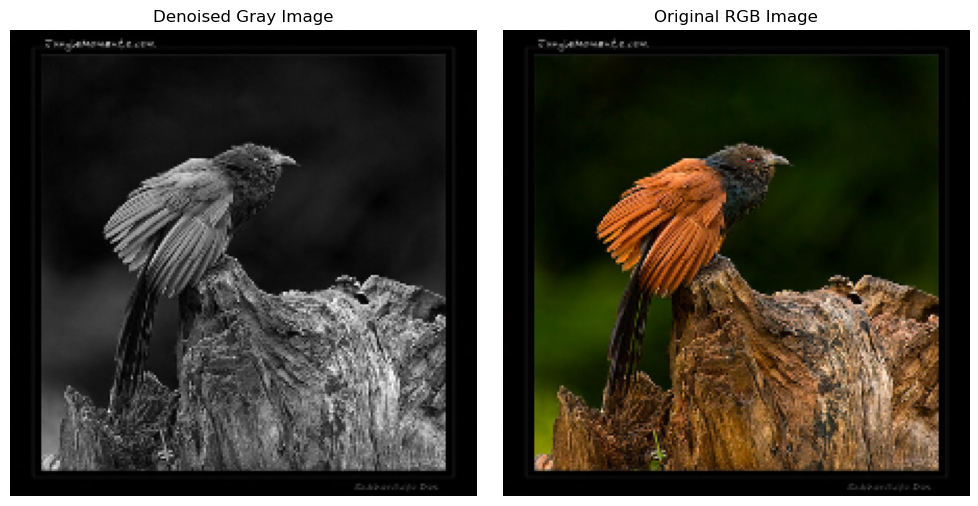

In [6]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(denoised_gray.squeeze().cpu().numpy(), cmap='gray')
axs[0].set_title("Denoised Gray Image")
axs[0].axis('off')

axs[1].imshow(original_rgb.squeeze(0).permute(1, 2, 0).cpu().numpy())
axs[1].set_title("Original RGB Image")
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [7]:
model = Restorer().to(DEVICE)
model.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR, "resnet_backbone_0.0001_0.01_10000_epoch_1_batch_30000.pth"))['model_state_dict'])
model.eval()

with torch.no_grad():
    uv_channels, rgb_upscaled = model(denoised_gray)

In [12]:
results_folder = '../results/checkpoint_30k/'
os.makedirs(results_folder, exist_ok=True)

for i, sample in enumerate(tqdm(noisy_val_dataset)):
    denoised_gray = sample['denoised_gray'].unsqueeze(0).to(DEVICE)
    original_rgb  = sample['original_rgb'].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        uv_channels, rgb_upscaled = model(denoised_gray)

    upscaled_original = F.interpolate(original_rgb, size=(2160, 4096), mode='bilinear', align_corners=False)
    upscaled_gray     = F.interpolate(denoised_gray, size=(2160, 4096), mode='bilinear', align_corners=False)

    denoised_gray_plt = upscaled_gray.squeeze().cpu().numpy()
    original_rgb_plt  = upscaled_original.squeeze().permute(1, 2, 0).cpu().numpy()
    pred_rgb_plt      = rgb_upscaled.squeeze().permute(1, 2, 0).cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(denoised_gray_plt, cmap='gray')
    axs[0].set_title("Denoised Gray")
    axs[0].axis('off')

    axs[1].imshow(original_rgb_plt)
    axs[1].set_title("Original RGB")
    axs[1].axis('off')

    axs[2].imshow(pred_rgb_plt)
    axs[2].set_title("Predicted RGB")
    axs[2].axis('off')

    plt.savefig(os.path.join(results_folder, f"{i}.png"), bbox_inches='tight')
    plt.close()

    if i == 100:
        break

100it [06:28,  3.88s/it]


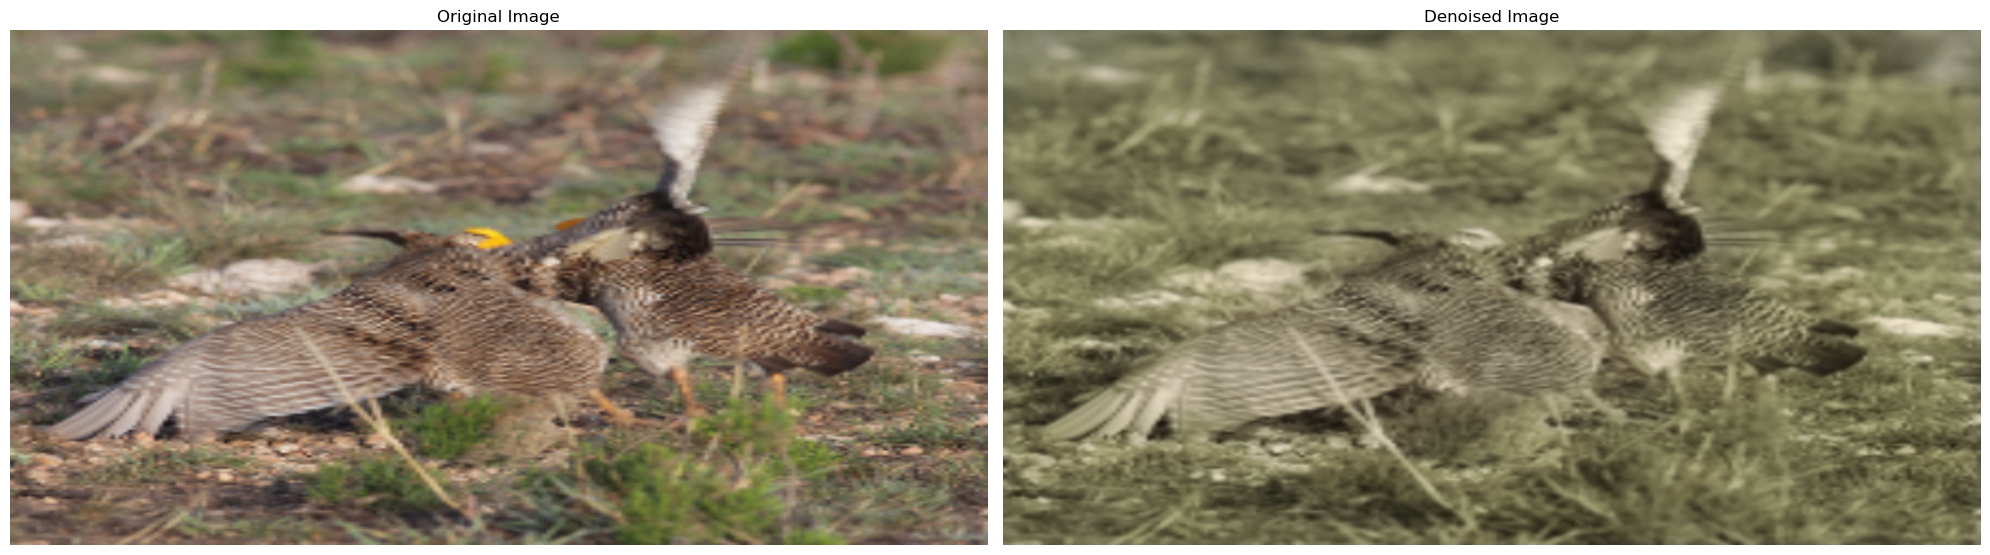

In [13]:
upscaled_original = F.interpolate(original_rgb, size=(2160, 4096), mode='bilinear', align_corners=False)

_, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(upscaled_original[0].permute(1, 2, 0).cpu().numpy())
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(rgb_upscaled[0].permute(1, 2, 0).cpu().numpy())
axs[1].set_title("Denoised Image")
axs[1].axis('off')

plt.tight_layout()
plt.show()

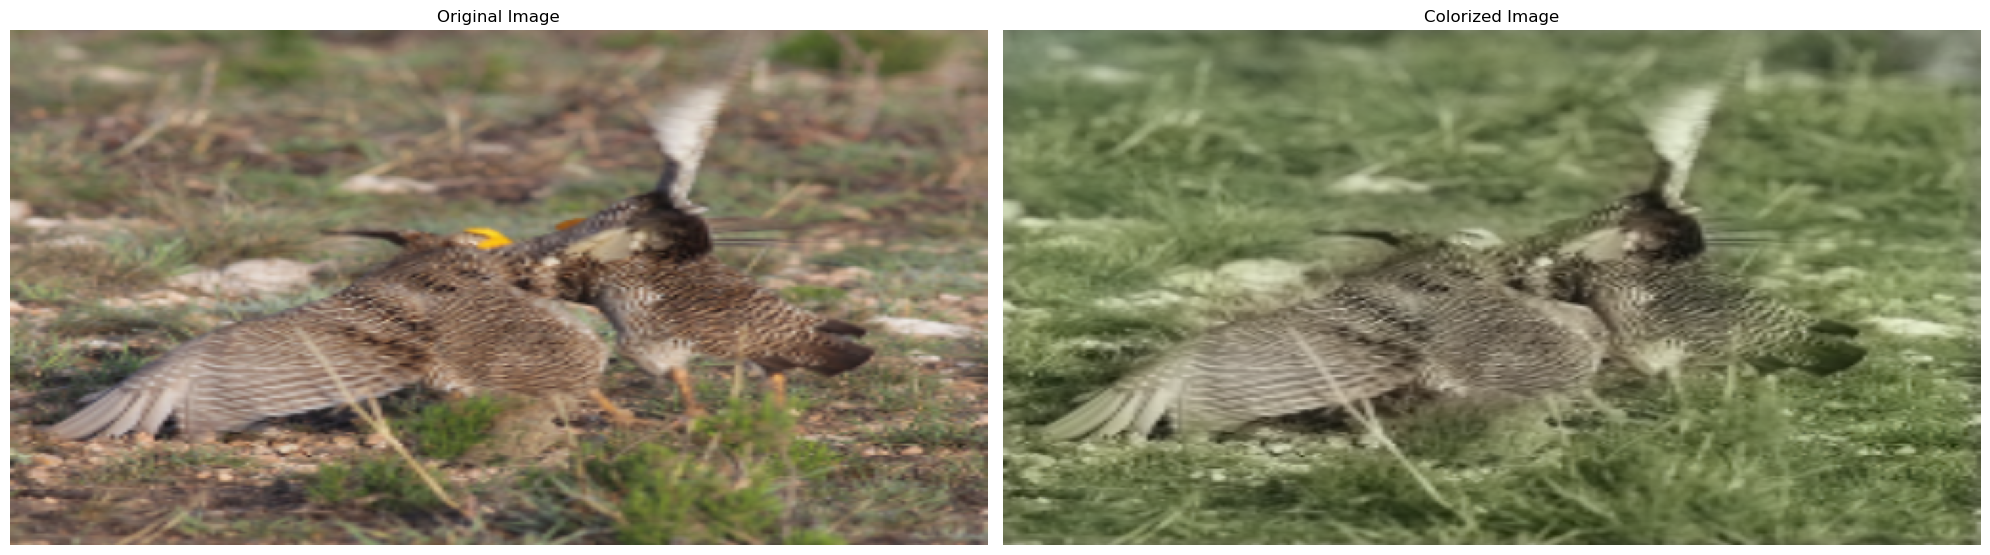

In [14]:
resized_denoised_gray = F.interpolate(denoised_gray, size=(270, 512), mode='bilinear', align_corners=False)
resized_original_rgb  = F.interpolate(original_rgb, size=(270, 512), mode='bilinear', align_corners=False)

colorizer_pred_rgb = model.uv_to_rgb(resized_denoised_gray, uv_channels)

_, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(resized_original_rgb[0].permute(1, 2, 0).cpu().numpy())
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(colorizer_pred_rgb[0].permute(1, 2, 0).cpu().numpy())
axs[1].set_title("Colorized Image")
axs[1].axis('off')

plt.tight_layout()
plt.show()